In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from importlib import reload

import flow.visualize.visualize_ring as visualize_ring

import torch
print(torch.__version__)

# Anti-Flow specific functions for  detection:
import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

import utils
reload(utils)
from utils import Bando_OVM_FTL

import os

print('Libraries loaded.')

1.7.1
Libraries loaded.


In [5]:
#Run with just one class of driver:
driver_controller_list = []
num_drivers = 20

sim_time = 1000
ring_length = 300

driver_controller_list = []
num_drivers = 20

a=0.8
b=20.0
s0=1.0
s1=2.0
Vm=15.0

label = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label,cfm_controller,num_drivers])
print('Simulation params initialized.')
print(driver_controller_list)

Simulation params initialized.
[['bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0', (<class 'utils.Bando_OVM_FTL'>, {'a': 0.8, 'b': 20.0, 's0': 1.0, 's1': 2.0, 'Vm': 15.0, 'noise': 0.1}), 20]]


In [6]:
import utils
reload(utils)
import time

sim_res_no_attack = utils.run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list,sim_time=1000)

Number unique drivers: 1
Error during start: [Errno 2] No such file or directory: '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/flow/core/kernel/network/debug/cfg/ring_variable_cfm_20220406-2325171649305517.9075289.net.xml'
Retrying in 1 seconds...
Error during start: [Errno 2] No such file or directory: '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/flow/core/kernel/network/debug/cfg/ring_variable_cfm_20220406-2325171649305517.9075289.net.xml'
Retrying in 1 seconds...
Error during start: [Errno 2] No such file or directory: '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/flow/core/kernel/network/debug/cfg/ring_variable_cfm_20220406-2325171649305517.9075289.net.xml'
Retrying in 1 seconds...
Error during start: [Errno 2] No such file or directory: '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/flow/core/kernel/network/debug/cfg/ring_variable_cfm_20220406-2325171649305517.9075289.net.xml'
Retrying in 1 seconds...
Error during start: [Errno 2] No such file or directory: '/

TypeError: exceptions must derive from BaseException

In [11]:
warmup_period = 500 #Wait until there's a well developed wave

emission_path_no_attack = os.path.join(os.getcwd(),sim_res_no_attack[1])
timeseries_dict_no_attack = visualize_ring.get_sim_timeseries(csv_path=emission_path_no_attack,
                                                              warmup_period=warmup_period)

Data loaded.


In [42]:
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model

def get_cnn_lstm_ae_model(n_features=1,seq_len=100):
    #Network specific hyper-params:
    embedding_dim = 32
    cnn_channels = 8
    kernel_size = 16
    stride = 1
    batch_size = 16
    device = 'cpu' #Change to cuda if appropriate
    n_features=n_features #Number of features, in the case only 1: speed
    seq_len = 100 #How many samples from the time-series we look at per time

    #initialize the CNN LSTM AutoEncoder:
    model = CNNRecurrentAutoencoder(seq_len,
                                    n_features,
                                    embedding_dim,
                                    cnn_channels, 
                                    kernel_size, 
                                    stride, 
                                    device)
    return model

print('Deep learning anom detect functions loaded.')

Deep learning anom detect functions loaded.


In [28]:
def make_train_X(timeseries_list,num_samples_per_veh = 100,seq_len = 100):
    '''Should accept a list of lists of numpy arrays which are all synced timeseries'''
    training_data_list = []
    for sample in timeseries_list:
        sample_length = len(sample[0])
        
        num_features = len(sample)
        
        sample_start_points = np.random.randint(sample_length-seq_len,size=num_samples_per_veh)
        for i in range(num_samples_per_veh):
            start = sample_start_points[i]
            end = start+seq_len
            
            training_data_sample = np.zeros([num_features*seq_len,1])
            
            for j in range(num_features):
                #j iterates through the different features:
                timeseries_measurement = sample[j][start:end]
                training_data_sample[j*seq_len:(j+1)*seq_len] = timeseries_measurement.reshape(seq_len,1)
            
            training_data_list.append(training_data_sample)
        
    #Cast into a torch Tensor:
    train_X = torch.Tensor(np.array(training_data_list))
    
    return train_X

In [1]:
import flow.visualize.visualize_ring
reload(flow.visualize.visualize_ring)
from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader

from copy import deepcopy
veh_ids_no_attack = list(timeseries_dict_no_attack.keys())

GPS_penetration_rate = 0.50
num_measured_vehicle_ids = int(np.floor(len(veh_ids_no_attack)*GPS_penetration_rate))
measured_veh_ids = deepcopy(veh_ids_no_attack)
for i in range(len(measured_veh_ids)-num_measured_vehicle_ids):
    rand_int = np.random.randint(0,len(measured_veh_ids))
    del measured_veh_ids[rand_int]

    
ring_sim_dict = visualize_ring.get_sim_data_dict_ring(csv_path=emission_path_no_attack,
                                                       warmup_period=warmup_period)



NameError: name 'reload' is not defined

In [106]:
timeseries_list = []

for veh_id in measured_veh_ids:
    #[time,speed,headway,accel,leader_speed,fuel_consumption]
    speed = timeseries_dict_no_attack[veh_id][:,1]
    accel = np.gradient(speed,.1)
    measured_leader = get_measured_leader(ring_sim_dict,veh_id,measured_veh_ids)
    leader_dist = get_rel_dist_to_measured_leader(ring_sim_dict,veh_id,measured_leader)
    leader_vel = get_vel_of_measured_leader(ring_sim_dict,veh_id,measured_leader)
    
    timeseries_list.append([speed,accel,leader_dist,leader_vel])
    
print('Timeseries list created')

Timeseries list created


In [107]:
train_X = make_train_X(timeseries_list)
# train_X = train_X.reshape(1000,400)
print('Training data prepared: '+str(train_X.shape))

Training data prepared: torch.Size([1000, 400, 1])


In [57]:
model = get_cnn_lstm_ae_model(n_features=4)
print('Model initialize.')

Model initialize.


In [66]:
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model

#Train the model:
import time

model_file_name = 'ring_50percentGPS'

print('Beginning training...')
begin_time = time.time()

model = train_model(model,train_X,model_file_name,n_epoch=100)
finish_time = time.time()
print('Finished training, total time: '+str(finish_time-begin_time))

Beginning training...
Epoch 0, total loss 56017.385468, total predictions 1000, avg loss 56.017385 2022-01-10 13:42:35.804020
Saving model. Best loss: 56.017385467529294
Saving model. Best loss: 54.016897735595705
Epoch 5, total loss 57532.714874, total predictions 1000, avg loss 57.532715 2022-01-10 13:42:55.410066
Saving model. Best loss: 52.55254742431641
Saving model. Best loss: 50.55915853881836
Epoch 10, total loss 53682.051025, total predictions 1000, avg loss 53.682051 2022-01-10 13:43:15.095450
Epoch 15, total loss 58205.583923, total predictions 1000, avg loss 58.205584 2022-01-10 13:43:35.744341
Saving model. Best loss: 49.250624389648436
Saving model. Best loss: 48.24024165344238
Epoch 20, total loss 52192.468689, total predictions 1000, avg loss 52.192469 2022-01-10 13:43:56.405990
Epoch 25, total loss 76064.832977, total predictions 1000, avg loss 76.064833 2022-01-10 13:44:16.902933
Epoch 30, total loss 77234.503662, total predictions 1000, avg loss 77.234504 2022-01-10 

In [67]:
save_path=os.path.join(os.getcwd(),'models/')
MODEL_PATH = os.path.join(save_path,'cnn_lstm_ae_ring_50percentGPS.pt')
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

In [69]:
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window_mult_feat

training_losses_dict = dict.fromkeys(measured_veh_ids)

measured_veh_data_dict = dict.fromkeys(measured_veh_ids)

num_veh_processed = 0

losses = []

for veh_id in measured_veh_ids:
    
    speed = timeseries_dict_no_attack[veh_id][:,1]
    accel = np.gradient(speed,.1)
    measured_leader = get_measured_leader(ring_sim_dict,veh_id,measured_veh_ids)
    leader_dist = get_rel_dist_to_measured_leader(ring_sim_dict,veh_id,measured_leader)
    leader_vel = get_vel_of_measured_leader(ring_sim_dict,veh_id,measured_leader)
    
    timeseries_list = [speed,accel,leader_dist,leader_vel]
    
    _,loss = sliding_window_mult_feat(model,timeseries_list)
    
    losses.append(loss)
    
    num_veh_processed+=1
    print('Vehicles processed: '+str(num_veh_processed))
    
print('Finished.')

Vehicles processed: 1
Vehicles processed: 2
Vehicles processed: 3
Vehicles processed: 4
Vehicles processed: 5
Vehicles processed: 6
Vehicles processed: 7
Vehicles processed: 8
Vehicles processed: 9
Vehicles processed: 10
Finished.


In [72]:
from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth

smoothed_losses = dict.fromkeys(measured_veh_ids)
time = timeseries_dict_no_attack[measured_veh_ids[0]][:,0]
#Get smoothed loss values:
for i in range(len(losses)):
    loss = losses[i]
    smoothed_losses[measured_veh_ids[i]] =  loss_smooth(time,loss)
    
print('Smoothed losses found.')   

Smoothed losses found.


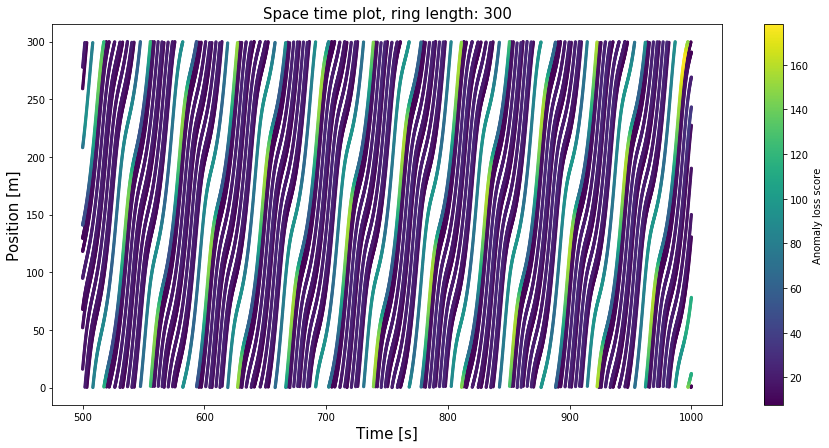

In [77]:
reload(visualize_ring)

measured_data_dict = dict.fromkeys(measured_veh_ids)

for veh_id in measured_veh_ids:
    measured_data_dict[veh_id] = ring_sim_dict[veh_id]

#Create the spacetime plot:
visualize_ring.make_ring_spacetime_fig_with_losses(smoothed_losses,
                                                   sim_data_dict=measured_data_dict,
                                                   ring_length=300)
  

In [154]:
# Run a simulation with an attacker present:
reload(utils)

import Adversaries.controllers.car_following_adversarial
from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact

#Run with two classes of driver:
driver_controller_list = []
num_drivers = 19

a=0.8
b=20.0
s0=1.0
s1=2.0
Vm=15.0

label_1 = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label_1,cfm_controller,num_drivers])

num_drivers = 19

a=0.7
b=18.0
s0=1.5
s1=2.5
Vm=13.0

label_1 = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label_1,cfm_controller,num_drivers])




v_des = 10.0
braking_period = 5.0
braking_rate = -2.0

adversary = (FollowerStopper_Overreact, {'v_des':v_des,
                                        'braking_rate':braking_rate,
                                        'braking_period':braking_period})

label_adv = 'FStop_vd'+str(v_des)+'_bperiod'+str(braking_period)+'_brate'+str(braking_rate)
driver_controller_list.append([label_adv,adversary,1])



v_des = 11.0
braking_period = 3.0
braking_rate = -3.0

adversary = (FollowerStopper_Overreact, {'v_des':v_des,
                                        'braking_rate':braking_rate,
                                        'braking_period':braking_period})

label_adv = 'FStop_vd'+str(v_des)+'_bperiod'+str(braking_period)+'_brate'+str(braking_rate)
driver_controller_list.append([label_adv,adversary,1])


print('Simulation params initialized: ')
print(driver_controller_list)

ring_length = 600

sim_res_list_with_attack = utils.run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list,ring_length = ring_length,sim_time=1000)

Simulation params initialized: 
[['bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0', (<class 'utils.Bando_OVM_FTL'>, {'a': 0.8, 'b': 20.0, 's0': 1.0, 's1': 2.0, 'Vm': 15.0, 'noise': 0.1}), 19], ['bando_ftl_ovm_a0.7_b18.0_s01.5_s12.5_Vm13.0', (<class 'utils.Bando_OVM_FTL'>, {'a': 0.7, 'b': 18.0, 's0': 1.5, 's1': 2.5, 'Vm': 13.0, 'noise': 0.1}), 19], ['FStop_vd10.0_bperiod5.0_brate-2.0', (<class 'Adversaries.controllers.car_following_adversarial.FollowerStopper_Overreact'>, {'v_des': 10.0, 'braking_rate': -2.0, 'braking_period': 5.0}), 1], ['FStop_vd11.0_bperiod3.0_brate-3.0', (<class 'Adversaries.controllers.car_following_adversarial.FollowerStopper_Overreact'>, {'v_des': 11.0, 'braking_rate': -3.0, 'braking_period': 3.0}), 1]]
Number unique drivers: 4
Running ring simulation, ring length: 600
Braking engaged, time 28.700000000000003
Braking engaged, time 34.5
Braking engaged, time 51.6
Braking engaged, time 63.7
Braking engaged, time 79.7
Braking engaged, time 104.30000000000001
Braking en

In [88]:
emission_path_with_attack = os.path.join(os.getcwd(),sim_res_list_with_attack[1])
timeseries_dict_with_attack = visualize_ring.get_sim_timeseries(csv_path=emission_path_with_attack,
                                                              warmup_period=warmup_period)

veh_ids_with_attack = list(timeseries_dict_with_attack.keys())

num_measured_vehicle_ids = int(np.floor(len(veh_ids_with_attack)*GPS_penetration_rate))
measured_veh_ids_with_attack = deepcopy(veh_ids_with_attack)
for i in range(len(measured_veh_ids_with_attack)-num_measured_vehicle_ids):
    rand_int = np.random.randint(0,len(measured_veh_ids_with_attack))
    del measured_veh_ids_with_attack[rand_int]

ring_sim_dict_with_attack = visualize_ring.get_sim_data_dict_ring(csv_path=emission_path_with_attack,
                                                       warmup_period=warmup_period)




Data loaded.
Data loaded.


In [91]:
if('FStop_vd10.0_bperiod5.0_brate-2.0_0' not in measured_veh_ids_with_attack):
    measured_veh_ids_with_attack.append('FStop_vd10.0_bperiod5.0_brate-2.0_0')


In [92]:
num_veh_processed = 0

testing_losses_dict = dict.fromkeys(veh_ids_with_attack)

for veh_id in measured_veh_ids_with_attack:
    
    speed = timeseries_dict_with_attack[veh_id][:,1]
    accel = np.gradient(speed,.1)
    measured_leader = get_measured_leader(ring_sim_dict_with_attack,veh_id,measured_veh_ids)
    leader_dist = get_rel_dist_to_measured_leader(ring_sim_dict_with_attack,veh_id,measured_leader)
    leader_vel = get_vel_of_measured_leader(ring_sim_dict_with_attack,veh_id,measured_leader)
    
    timeseries_list = [speed,accel,leader_dist,leader_vel]
    
    _,loss = sliding_window_mult_feat(model,timeseries_list)
    
    testing_losses_dict[veh_id]=loss
    
    num_veh_processed+=1
    print('Vehicles processed: '+str(num_veh_processed))
    
print('Finished.')

Vehicles processed: 1
Vehicles processed: 2
Vehicles processed: 3
Vehicles processed: 4
Vehicles processed: 5
Vehicles processed: 6
Vehicles processed: 7
Vehicles processed: 8
Vehicles processed: 9
Vehicles processed: 10
Vehicles processed: 11
Finished.


Smoothed losses found.


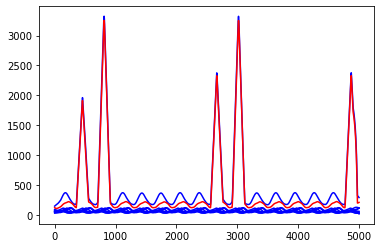

In [104]:
smoothed_losses_with_attack = dict.fromkeys(measured_veh_ids_with_attack)
time = timeseries_dict_with_attack[measured_veh_ids_with_attack[0]][:,0]

plt.figure()

#Get smoothed loss values:
for veh_id in measured_veh_ids_with_attack:
    loss = testing_losses_dict[veh_id]
    smoothed_loss = loss_smooth(time,loss)
    
    if(veh_id == 'FStop_vd10.0_bperiod5.0_brate-2.0_0'):
        plt.plot(smoothed_loss,'r')
    else:
        plt.plot(smoothed_loss,'b')
    smoothed_losses_with_attack[veh_id] =  loss_smooth(time,loss)
    
print('Smoothed losses found.')   

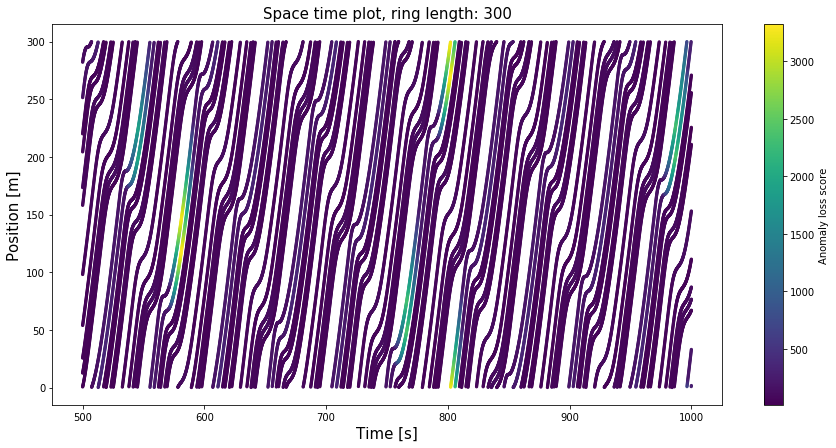

In [103]:
reload(visualize_ring)

measured_data_dict_with_attack = dict.fromkeys(measured_veh_ids_with_attack)

for veh_id in measured_veh_ids_with_attack:
    measured_data_dict_with_attack[veh_id] = ring_sim_dict_with_attack[veh_id]

#Create the spacetime plot:
visualize_ring.make_ring_spacetime_fig_with_losses(smoothed_losses_with_attack,
                                                   sim_data_dict=measured_data_dict_with_attack,
                                                   ring_length=300)



In [135]:
reload(Detectors.Deep_Learning.AutoEncoders.utils)
reload(utils)

from Detectors.Deep_Learning.AutoEncoders.utils import get_cnn_lstm_ae_model
from utils import train_ring_relative_detector

print('Detector training functions loaded.')

ring_length = 300
GPS_penetration_rate = 1.0
emission_path = emission_path_no_attack

model_100percentGPS = train_ring_relative_detector(GPS_penetration_rate,ring_length,emission_path,n_epoch=300)

Detector training functions loaded.
Data loaded.
Data loaded.
Model: ringlength300_1.0percentGPS
Beginning training...
Epoch 0, total loss 106367.561279, total predictions 2000, avg loss 53.183781 2022-01-11 11:42:23.484856
Saving model. Best loss: 53.18378063964844
Saving model. Best loss: 52.93540856933594
Saving model. Best loss: 52.89581280517578
Saving model. Best loss: 52.877069915771486
Saving model. Best loss: 52.86578540039063
Epoch 5, total loss 105715.920959, total predictions 2000, avg loss 52.857960 2022-01-11 11:43:03.502676
Saving model. Best loss: 52.85796047973633
Saving model. Best loss: 52.85203823852539
Saving model. Best loss: 52.84731448364258
Saving model. Best loss: 52.84341766357422
Saving model. Best loss: 52.84013555908203
Epoch 10, total loss 105674.665039, total predictions 2000, avg loss 52.837333 2022-01-11 11:43:44.186614
Saving model. Best loss: 52.83733251953125
Saving model. Best loss: 52.83491241455078
Saving model. Best loss: 52.83280892944336
Savin

Epoch 175, total loss 2921.662025, total predictions 2000, avg loss 1.460831 2022-01-11 12:07:46.438583
Epoch 180, total loss 3069.311058, total predictions 2000, avg loss 1.534656 2022-01-11 12:08:30.916733
Epoch 185, total loss 3344.227463, total predictions 2000, avg loss 1.672114 2022-01-11 12:09:14.887767
Epoch 190, total loss 2517.372517, total predictions 2000, avg loss 1.258686 2022-01-11 12:09:59.274520
Epoch 195, total loss 2509.832790, total predictions 2000, avg loss 1.254916 2022-01-11 12:10:43.799391
Saving model. Best loss: 1.012019654750824
Epoch 200, total loss 2680.756628, total predictions 2000, avg loss 1.340378 2022-01-11 12:11:28.248104
Epoch 205, total loss 2269.899714, total predictions 2000, avg loss 1.134950 2022-01-11 12:12:12.746646
Epoch 210, total loss 3147.361177, total predictions 2000, avg loss 1.573681 2022-01-11 12:12:57.001596
Saving model. Best loss: 0.9106938161849976
Epoch 215, total loss 3578.299667, total predictions 2000, avg loss 1.789150 2022

In [155]:
def assess_relative_model_on_attack(emission_path,GPS_penetration_rate,model,want_timeseries_plot=True):
    print('Finding losses on attack simulation.')
    timeseries_dict = visualize_ring.get_sim_timeseries(csv_path=emission_path,
                                                                  warmup_period=warmup_period)

    veh_ids = list(timeseries_dict.keys())

    num_measured_vehicle_ids = int(np.floor(len(veh_ids)*GPS_penetration_rate))
    measured_veh_ids = deepcopy(veh_ids)
    for i in range(len(measured_veh_ids)-num_measured_vehicle_ids):
        rand_int = np.random.randint(0,len(measured_veh_ids))
        del measured_veh_ids[rand_int]

    ring_sim_dict = visualize_ring.get_sim_data_dict_ring(csv_path=emission_path,
                                                           warmup_period=warmup_period)
    adv_label = 'FStop' #
    for veh_id in veh_ids:
        if(adv_label in veh_id and veh_id not in measured_veh_ids):
            measured_veh_ids.append(veh_id)
            
    print('Number of vehicles measured: '+str(num_measured_vehicle_ids))
        
    num_veh_processed = 0

    testing_losses_dict = dict.fromkeys(veh_ids)

    for veh_id in measured_veh_ids:

        speed = timeseries_dict[veh_id][:,1]
        accel = np.gradient(speed,.1)
        measured_leader = get_measured_leader(ring_sim_dict,veh_id,measured_veh_ids)
        leader_dist = get_rel_dist_to_measured_leader(ring_sim_dict,veh_id,measured_leader)
        leader_vel = get_vel_of_measured_leader(ring_sim_dict,veh_id,measured_leader)

        timeseries_list = [speed,accel,leader_dist,leader_vel]

        _,loss = sliding_window_mult_feat(model,timeseries_list)

        testing_losses_dict[veh_id]=loss

        num_veh_processed+=1
        print('Vehicles processed: '+str(num_veh_processed))

    print('Finished.')
    
    smoothed_losses = dict.fromkeys(measured_veh_ids)
    time = timeseries_dict[measured_veh_ids[0]][:,0]
    
    #Get smoothed loss values:
    for veh_id in measured_veh_ids:
        loss = testing_losses_dict[veh_id]
        smoothed_loss = loss_smooth(time,loss)
            
        smoothed_losses[veh_id] =  loss_smooth(time,loss)

    print('Smoothed losses found.')
    
    if(want_timeseries_plot):
        plt.figure()
        
        for veh_id in measured_veh_ids:
            smoothed_loss = smoothed_losses[veh_id]
            if(adv_label in veh_id):
                plt.plot(smoothed_loss,'r')
            else:
                plt.plot(smoothed_loss,'b')
        
    return smoothed_losses

print('Assess model function defined.')

Assess model function defined.


In [136]:
GPS_penetration_rate=1.0
model = get_cnn_lstm_ae_model(n_features=4)
save_path=os.path.join(os.getcwd(),'models/')
MODEL_PATH = os.path.join(save_path,'cnn_lstm_ae_ringlength300_'+str(GPS_penetration_rate)+'percentGPS.pt')
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

Finding losses on attack simulation.
Data loaded.
Data loaded.
Number of vehicles measured: 40
Vehicles processed: 1
Vehicles processed: 2
Vehicles processed: 3
Vehicles processed: 4
Vehicles processed: 5
Vehicles processed: 6
Vehicles processed: 7
Vehicles processed: 8
Vehicles processed: 9
Vehicles processed: 10
Vehicles processed: 11
Vehicles processed: 12
Vehicles processed: 13
Vehicles processed: 14
Vehicles processed: 15
Vehicles processed: 16
Vehicles processed: 17
Vehicles processed: 18
Vehicles processed: 19
Vehicles processed: 20
Vehicles processed: 21
Vehicles processed: 22
Vehicles processed: 23
Vehicles processed: 24
Vehicles processed: 25
Vehicles processed: 26
Vehicles processed: 27
Vehicles processed: 28
Vehicles processed: 29
Vehicles processed: 30
Vehicles processed: 31
Vehicles processed: 32
Vehicles processed: 33
Vehicles processed: 34
Vehicles processed: 35
Vehicles processed: 36
Vehicles processed: 37
Vehicles processed: 38
Vehicles processed: 39
Vehicles processe

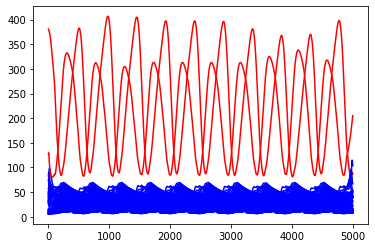

In [156]:
emission_path_with_attack = os.path.join(os.getcwd(),sim_res_list_with_attack[1])
smoothed_losses_100_percent = assess_model_on_attack(emission_path_with_attack,GPS_penetration_rate,model)

In [ ]:
measured_veh_ids_with_attack = list(smoothed_losses_100_percent.keys())

plt.figure()


In [161]:
import os
import matplotlib.pyplot as plt
import flow.visualize.visualize_ring
reload(flow.visualize.visualize_ring)
from flow.visualize.visualize_ring import get_sim_timeseries,get_sim_data_dict_ring,get_ring_positions,stack_data_for_spacetime
from copy import deepcopy

csv_path = emission_path_with_attack

# csv_path = '/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/detector_dev/data/ring_variable_cfm_20220112-2037411642041461.872571-0_emission.csv'

warmup_period = 900

sim_data_dict_full = get_sim_data_dict_ring(csv_path,warmup_period=900)

timeseries_data_dict = get_sim_timeseries(csv_path,warmup_period=900)

# measured_veh_ids = list(smoothed_losses_100_percent.keys())

# smoothed_losses_current = dict.fromkeys(measured_veh_ids)

Data loaded.
Data loaded.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Make figures with space time with losses, and then timeseries at 100 percent GPS

In [167]:
import utils
reload(utils)
from utils import assess_relative_model_on_attack

import os
import matplotlib.pyplot as plt
import flow.visualize.visualize_ring
reload(flow.visualize.visualize_ring)
from flow.visualize.visualize_ring import get_sim_timeseries,get_sim_data_dict_ring,get_ring_positions,stack_data_for_spacetime
from copy import deepcopy

csv_path = emission_path_with_attack

# csv_path = '/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/detector_dev/data/ring_variable_cfm_20220112-2037411642041461.872571-0_emission.csv'

warmup_period = 900

sim_data_dict_full = get_sim_data_dict_ring(csv_path,warmup_period=900)

timeseries_data_dict = get_sim_timeseries(csv_path,warmup_period=900)

GPS_penetration_rate=1.0
model = get_cnn_lstm_ae_model(n_features=4)
save_path=os.path.join(os.getcwd(),'models/')
MODEL_PATH = os.path.join(save_path,'cnn_lstm_ae_ringlength300_'+str(GPS_penetration_rate)+'percentGPS_relative.pt')
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))

smoothed_losses_100_percent = assess_relative_model_on_attack(emission_path=emission_path_with_attack,
                                                              GPS_penetration_rate=GPS_penetration_rate,
                                                              model=model,
                                                              want_timeseries_plot=False,
                                                              warmup_period=warmup_period)
ring_length = 600

sim_data_dict = dict.fromkeys(measured_veh_ids)

for veh_id in measured_veh_ids:
    sim_data_dict[veh_id] = sim_data_dict_full[veh_id]

veh_ids = list(sim_data_dict.keys())
ring_positions = get_ring_positions(sim_data_dict,ring_length)

times,positions,speeds,losses = stack_data_for_spacetime(sim_data_dict,
                                                         ring_positions,
                                                         want_losses=True,
                                                         losses_dict=smoothed_losses_100_percent)

positions_mod_ring_length = np.mod(positions,ring_length)

fontsize = 25
dot_size = 8.0

plt.figure(figsize=[20,7])

#Space time:
# plt.subplot(2,1,1)
plt.scatter(times,positions_mod_ring_length,c=losses,s=dot_size)
plt.ylabel('Position [m]',fontsize=fontsize)
plt.xlabel('Time [s]',fontsize=fontsize)

plt.xlim([900,1000])
plt.ylim([0,ring_length])

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# cbar = plt.colorbar(label='Reconstruction loss')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)

plt.title('Anomaly detection at 100% observation rate.',fontsize=fontsize)


# Timeseries:
# plt.subplot(2,1,2)

fontsize = 30

plt.figure(figsize=[20,7])

benign_veh_id = None
mal_veh_id = None

for veh_id in smoothed_losses:
    if('FStop' in veh_id):
        t = timeseries_data_dict[veh_id][:,0]
        l = smoothed_losses_100_percent[veh_id]
        plt.plot(t,l,'r',linewidth=2)
        mal_veh_id = veh_id
    else:
        t = timeseries_data_dict[veh_id][:,0]
        l = smoothed_losses_100_percent[veh_id]
        plt.plot(t,l,'b')
        benign_veh_id = veh_id

# print(mal_veh_id)
# print(benign_veh_id)



t = timeseries_data_dict[mal_veh_id][:,0]
l = smoothed_losses_100_percent[mal_veh_id]
plt.plot(t,l,'r',linewidth=2,label='Compromised')

t = timeseries_data_dict[benign_veh_id][:,0]
l = smoothed_losses_100_percent[benign_veh_id]
plt.plot(t,l,'b',label='Benign')


plt.legend(fontsize=fontsize-5)
plt.xlim([900,1000])
plt.ylabel('Reconstruction loss',fontsize=fontsize)
plt.xlabel('Time[s]',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.show()  

Finding losses on attack simulation.
Data loaded.
Data loaded.
Number of vehicles measured: 40
Vehicles processed: 40

Finished.


In [168]:
ring_length = 600

sim_data_dict = dict.fromkeys(measured_veh_ids)

for veh_id in measured_veh_ids:
    sim_data_dict[veh_id] = sim_data_dict_full[veh_id]

veh_ids = list(sim_data_dict.keys())
ring_positions = get_ring_positions(sim_data_dict,ring_length)

times,positions,speeds,losses = stack_data_for_spacetime(sim_data_dict,
                                                         ring_positions,
                                                         want_losses=True,
                                                         losses_dict=smoothed_losses_100_percent)

print('Finished')

Finished


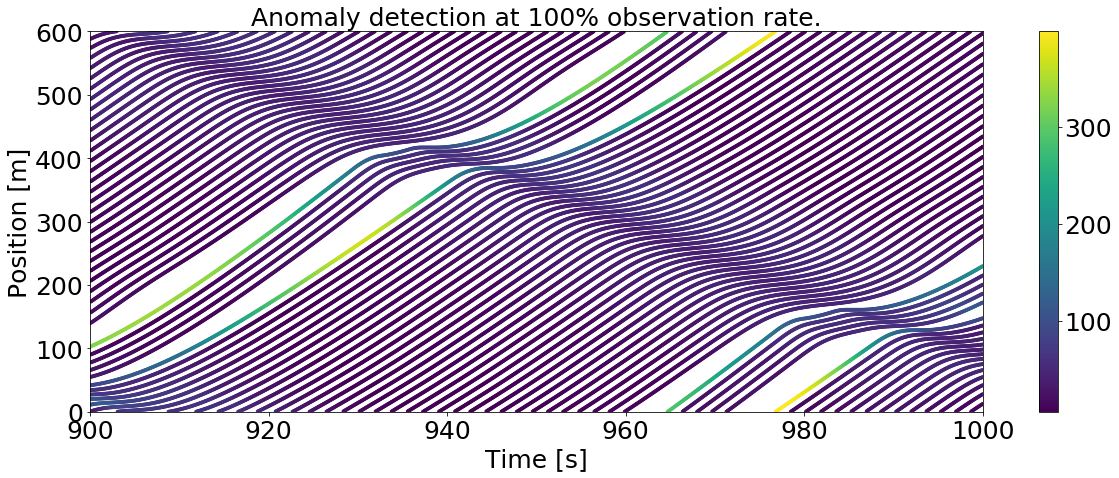

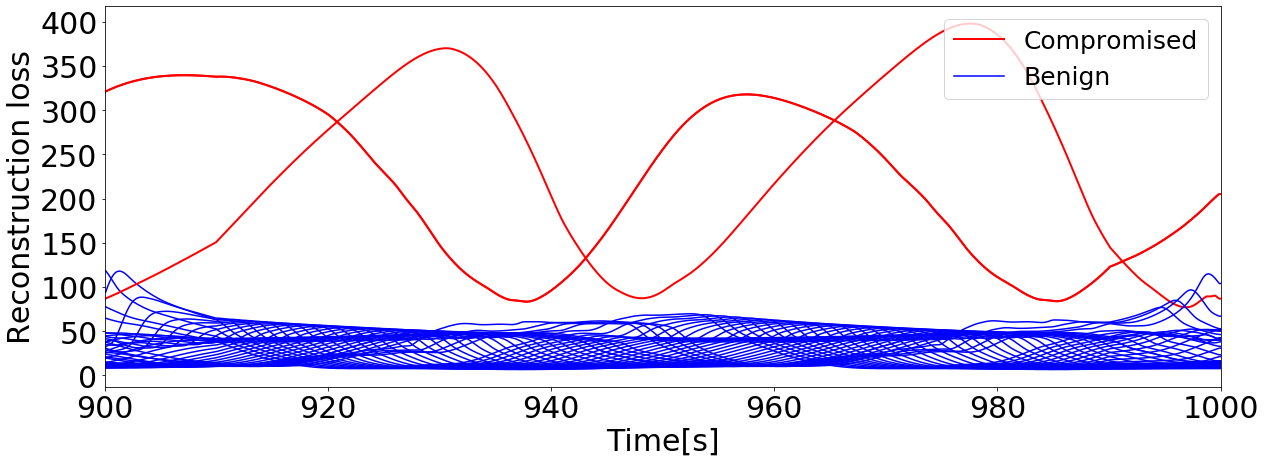

In [185]:
positions_mod_ring_length = np.mod(positions,ring_length)

fontsize = 25
dot_size = 8.0

plt.figure(figsize=[20,7])

#Space time:
# plt.subplot(2,1,1)
plt.scatter(times,positions_mod_ring_length,c=losses,s=dot_size)
plt.ylabel('Position [m]',fontsize=fontsize)
plt.xlabel('Time [s]',fontsize=fontsize)

plt.xlim([900,1000])
plt.ylim([0,ring_length])

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# cbar = plt.colorbar(label='Reconstruction loss')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)

plt.title('Anomaly detection at 100% observation rate.',fontsize=fontsize)


# Timeseries:
# plt.subplot(2,1,2)

fontsize = 30

plt.figure(figsize=[20,7])

benign_veh_id = None
mal_veh_id = None

for veh_id in smoothed_losses:
    if('FStop' in veh_id):
        t = timeseries_data_dict[veh_id][:,0]
        l = smoothed_losses_100_percent[veh_id]
        plt.plot(t,l,'r',linewidth=2)
        mal_veh_id = veh_id
    else:
        t = timeseries_data_dict[veh_id][:,0]
        l = smoothed_losses_100_percent[veh_id]
        plt.plot(t,l,'b')
        benign_veh_id = veh_id

# print(mal_veh_id)
# print(benign_veh_id)



t = timeseries_data_dict[mal_veh_id][:,0]
l = smoothed_losses_100_percent[mal_veh_id]
plt.plot(t,l,'r',linewidth=2,label='Compromised')

t = timeseries_data_dict[benign_veh_id][:,0]
l = smoothed_losses_100_percent[benign_veh_id]
plt.plot(t,l,'b',label='Benign')


plt.legend(fontsize=fontsize-5)
plt.xlim([900,1000])
plt.ylabel('Reconstruction loss',fontsize=fontsize)
plt.xlabel('Time[s]',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.show()  

## Recreate above but at 50 percent GPS penetration rate:

Data loaded.
Data loaded.
Finding losses on attack simulation.
Data loaded.
Data loaded.
Number of vehicles measured: 20
Vehicles processed: 20



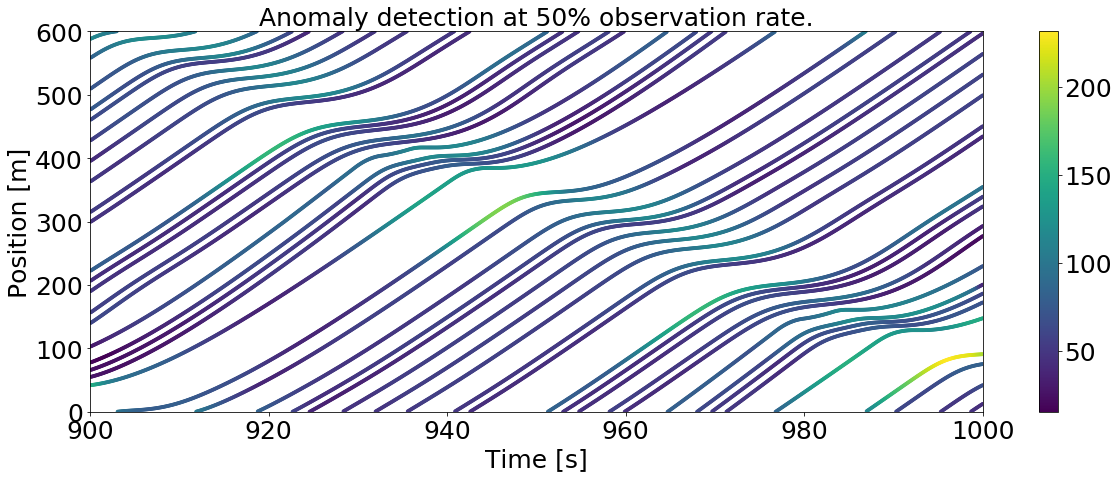

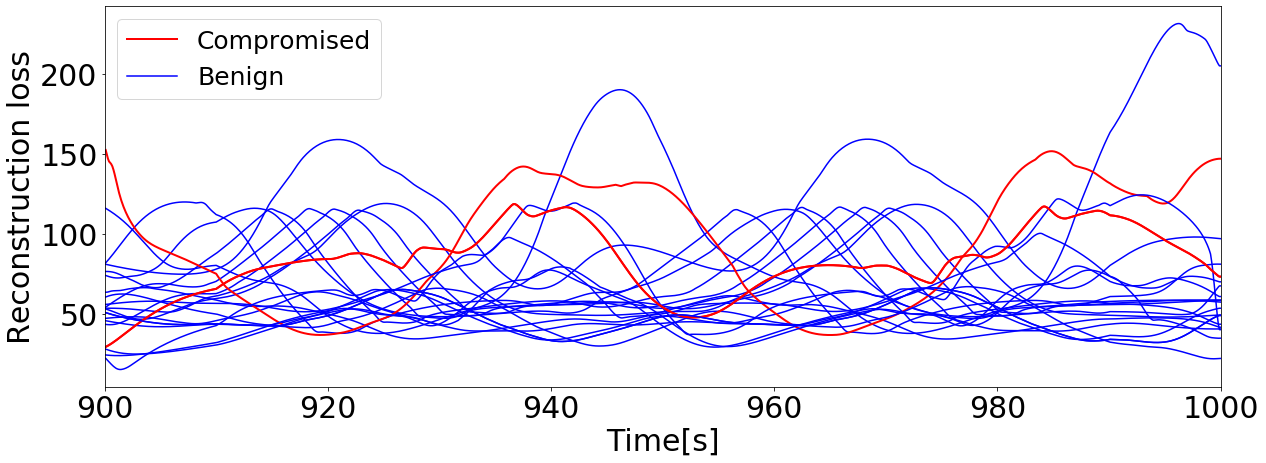

In [188]:
import utils
reload(utils)
from utils import assess_relative_model_on_attack

import os
import matplotlib.pyplot as plt
import flow.visualize.visualize_ring
reload(flow.visualize.visualize_ring)
from flow.visualize.visualize_ring import get_sim_timeseries,get_sim_data_dict_ring,get_ring_positions,stack_data_for_spacetime
from copy import deepcopy

csv_path = emission_path_with_attack

warmup_period = 900

sim_data_dict_full = get_sim_data_dict_ring(csv_path,warmup_period=900)

timeseries_data_dict = get_sim_timeseries(csv_path,warmup_period=900)

GPS_penetration_rate=0.5
model = get_cnn_lstm_ae_model(n_features=4)
save_path=os.path.join(os.getcwd(),'models/')
MODEL_PATH = os.path.join(save_path,'cnn_lstm_ae_ringlength300_'+str(GPS_penetration_rate)+'percentGPS_relative.pt')
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))

smoothed_losses_50_percent = assess_relative_model_on_attack(emission_path=emission_path_with_attack,
                                                              GPS_penetration_rate=GPS_penetration_rate,
                                                              model=model,
                                                              want_timeseries_plot=False,
                                                              warmup_period=warmup_period)

measured_veh_ids = list(smoothed_losses_50_percent.keys())

ring_length = 600

sim_data_dict = dict.fromkeys(measured_veh_ids)

for veh_id in measured_veh_ids:
    sim_data_dict[veh_id] = sim_data_dict_full[veh_id]

veh_ids = list(sim_data_dict.keys())
ring_positions = get_ring_positions(sim_data_dict,ring_length)

times,positions,speeds,losses = stack_data_for_spacetime(sim_data_dict,
                                                         ring_positions,
                                                         want_losses=True,
                                                         losses_dict=smoothed_losses_50_percent)

positions_mod_ring_length = np.mod(positions,ring_length)

fontsize = 25
dot_size = 8.0

plt.figure(figsize=[20,7])

#Space time:
# plt.subplot(2,1,1)
plt.scatter(times,positions_mod_ring_length,c=losses,s=dot_size)
plt.ylabel('Position [m]',fontsize=fontsize)
plt.xlabel('Time [s]',fontsize=fontsize)

plt.xlim([900,1000])
plt.ylim([0,ring_length])

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# cbar = plt.colorbar(label='Reconstruction loss')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)

plt.title('Anomaly detection at 50% observation rate.',fontsize=fontsize)


# Timeseries:
# plt.subplot(2,1,2)

fontsize = 30

plt.figure(figsize=[20,7])

benign_veh_id = None
mal_veh_id = None

for veh_id in measured_veh_ids:
    if('FStop' in veh_id):
        t = timeseries_data_dict[veh_id][:,0]
        l = smoothed_losses_50_percent[veh_id]
        plt.plot(t,l,'r',linewidth=2)
        mal_veh_id = veh_id
    else:
        t = timeseries_data_dict[veh_id][:,0]
        l = smoothed_losses_50_percent[veh_id]
        plt.plot(t,l,'b')
        benign_veh_id = veh_id

# print(mal_veh_id)
# print(benign_veh_id)



t = timeseries_data_dict[mal_veh_id][:,0]
l = smoothed_losses_50_percent[mal_veh_id]
plt.plot(t,l,'r',linewidth=2,label='Compromised')

t = timeseries_data_dict[benign_veh_id][:,0]
l = smoothed_losses_50_percent[benign_veh_id]
plt.plot(t,l,'b',label='Benign')


plt.legend(fontsize=fontsize-5)
plt.xlim([900,1000])
plt.ylabel('Reconstruction loss',fontsize=fontsize)
plt.xlabel('Time[s]',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.show()

# Misc:

Data loaded.


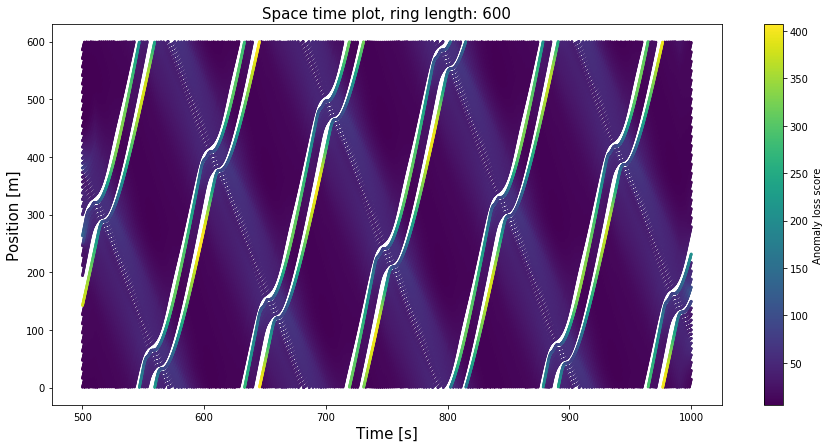

In [157]:
reload(visualize_ring)

ring_sim_dict_with_attack = visualize_ring.get_sim_data_dict_ring(csv_path=emission_path_with_attack,
                                                       warmup_period=warmup_period)

smoothed_losses_with_attack = smoothed_losses

measured_veh_ids_with_attack = list(smoothed_losses_with_attack.keys())

measured_data_dict_with_attack = dict.fromkeys(measured_veh_ids_with_attack)

for veh_id in measured_veh_ids_with_attack:
    measured_data_dict_with_attack[veh_id] = ring_sim_dict_with_attack[veh_id]

#Create the spacetime plot:
visualize_ring.make_ring_spacetime_fig_with_losses(smoothed_losses_with_attack,
                                                   sim_data_dict=measured_data_dict_with_attack,
                                                   ring_length=ring_length)

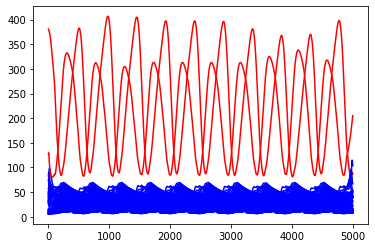

In [158]:
plt.figure(figsize=[10,5])

adv_veh_ids = []
benign_veh_ids = []


for veh_id in measured_veh_ids_with_attack:
    smoothed_loss = smoothed_losses[veh_id]
    if('FStop' in veh_id):
        plt.plot(smoothed_loss,'r',label='Adversary')
    
    
    
    if('FStop' not in veh_id):
        plt.plot(smoothed_loss,'b')

    

In [ ]:
# Run a simulation with an attacker present:
reload(utils)

import Adversaries.controllers.car_following_adversarial
from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact

#Run with two classes of driver:
driver_controller_list = []
num_drivers = 19

a=0.8
b=20.0
s0=1.0
s1=2.0
Vm=15.0

label_1 = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label_1,cfm_controller,num_drivers])

num_drivers = 19

a=0.7
b=18.0
s0=1.5
s1=2.5
Vm=13.0

label_1 = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label_1,cfm_controller,num_drivers])




v_des = 10.0
braking_period = 5.0
braking_rate = -2.0

adversary = (FollowerStopper_Overreact, {'v_des':v_des,
                                        'braking_rate':braking_rate,
                                        'braking_period':braking_period})

label_adv = 'FStop_vd'+str(v_des)+'_bperiod'+str(braking_period)+'_brate'+str(braking_rate)
driver_controller_list.append([label_adv,adversary,1])



v_des = 11.0
braking_period = 3.0
braking_rate = -3.0

adversary = (FollowerStopper_Overreact, {'v_des':v_des,
                                        'braking_rate':braking_rate,
                                        'braking_period':braking_period})

label_adv = 'FStop_vd'+str(v_des)+'_bperiod'+str(braking_period)+'_brate'+str(braking_rate)
driver_controller_list.append([label_adv,adversary,1])


print('Simulation params initialized: ')
print(driver_controller_list)

ring_length = 600

sim_res_list_with_attack = utils.run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list,ring_length = ring_length,sim_time=1000)